In [42]:
import numpy as np
import matplotlib.pyplot as plt

## Deterministic

In [43]:
# Constants
sigma = 0.001
beta = 100
lamda = 0.6
alpha = 0.1
v0 = 0.01
vg = 0
psi = np.inf
D = 18

t0 = 0.0
tf = 5000
steps = 10000

def var(vec, t):
    return np.array([0,0,np.sqrt(2*D)])

def velocity(vec, t):
    x, z, phi = vec
    dxdt    =       alpha*np.exp(z)*np.cos(x-t)       + v0*np.sin(phi)  + sigma*(beta+z)
    dzdt    =       alpha*np.exp(z)*np.sin(x-t)       + v0*np.cos(phi)  - vg
    dphidt  = lamda*alpha*np.exp(z)*np.cos(x-t+2*phi) - 1/(2*psi)*np.sin(phi)    + sigma/2*(1+lamda*np.cos(2*phi))

    return np.array([dxdt, dzdt, dphidt])

def integrator(method, vec0, t0, tf, steps):
    dt = (tf - t0) / steps
    t = np.linspace(t0, tf, steps+1)
    traj = np.zeros((steps, len(vec0)))
    traj[0] = vec0

    for i in range(1, steps):
        traj[i] = method(traj[i-1], t0 + i*dt, dt)

    return traj, t

def euler_step(vec, t, dt):
    
    return vec + velocity(vec, t) * dt

def rk4_step(vec, t, dt):
    k1 = velocity(vec, t)
    k2 = velocity(vec + 0.5 * dt * k1, t + 0.5 * dt)
    k3 = velocity(vec + 0.5 * dt * k2, t + 0.5 * dt)
    k4 = velocity(vec + dt * k3, t + dt)

    return vec + (dt / 6) * (k1 + 2*k2 + 2*k3 + k4)

def euler_marayama_step(vec, t, dt):
    # TODO:
    dW = np.random.normal(0, dt, size=len(vec))

    return vec + velocity(vec, t) * dt + var(vec,t) * dW    # var(vec,t) = 0,0,D_phi

def multiple_starting_conditions(method, num_trajectories, vec0, t0, tf, steps, perturbations):
    all_traj = np.zeros((num_trajectories, steps, len(vec0)))

    for i in range(num_trajectories):
        
        vec0_perturbed = vec0 + perturbations[i]  
        all_traj[i], _ = integrator(method, vec0_perturbed, t0, tf, steps)
    
    return all_traj

def mask_and_wrap_phi(path, y_idx=1, phi_idx=2, y_min=-10, y_max=0):
    path = np.asarray(path)
    y = path[:, y_idx]
    phi = path[:, phi_idx]

    mask = (y <= y_max) & (y >= y_min)

    phip = np.mod(phi[mask], 2*np.pi)
    phipp = np.where(phip >= np.pi, phip - 2*np.pi, phip)

    return phipp, y[mask], mask


# Initial conditions
vec0 = np.array([0.0, 0, -0.5*np.pi])

perturbations = [
    # np.array([0.0, -1, 0.0]),  
    np.array([0.0, -1, 0.0]),
    np.array([0.0, -2, 0.0]),
    np.array([0.0, -2.5, 0.0]),
    np.array([0.0, -3, 0.0]),
    np.array([0.0, -2.8, 0.0]),
    # np.array([0.0, -8, 0.0]),
]

num_trajectories = len(perturbations)  

t = np.linspace(t0, tf, steps+1)

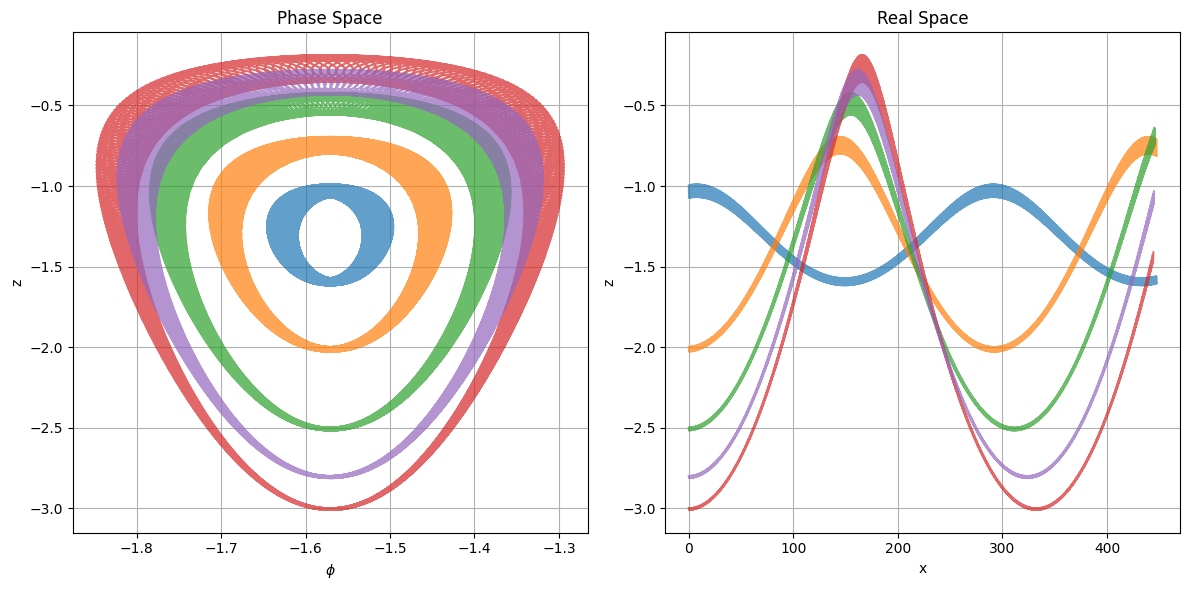

(<Figure size 1200x600 with 2 Axes>,
 (<Axes: title={'center': 'Phase Space'}, xlabel='$\\phi$', ylabel='z'>,
  <Axes: title={'center': 'Real Space'}, xlabel='x', ylabel='z'>))

In [44]:
def plot_phase_and_real_space(
    multi_traj,
    mask_fn=mask_and_wrap_phi,
    y_idx=1,
    x_idx=0,
    phi_idx=2,
    y_min=-10,
    y_max=0,
    alpha=0.7,
    figsize=(12, 6),
    show=True
):
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)

    # Phase space: phi vs z (masked & wrapped)
    for path in multi_traj:
        phipp, y_masked, _ = mask_fn(
            path, y_idx=y_idx, phi_idx=phi_idx, y_min=y_min, y_max=y_max
        )
        if len(y_masked) == 0:
            continue
        ax1.plot(phipp, y_masked, alpha=alpha)

    ax1.set_xlabel(r'$\phi$')
    ax1.set_ylabel('z')
    ax1.set_title('Phase Space')
    ax1.grid(True)

    # Real space: x vs z (masked)
    for path in multi_traj:
        path = np.asarray(path)
        y = path[:, y_idx]
        mask = (y <= y_max) & (y >= y_min)
        if not np.any(mask):
            continue
        ax2.plot(path[:, x_idx][mask], y[mask], alpha=alpha)

    ax2.set_xlabel('x')
    ax2.set_ylabel('z')
    ax2.set_title('Real Space')
    ax2.grid(True)

    plt.tight_layout()
    if show:
        plt.show()

    return fig, (ax1, ax2)


multi_start_cond = multiple_starting_conditions(rk4_step,num_trajectories, vec0, t0, tf, steps, perturbations)

plot_phase_and_real_space(multi_start_cond)

In [45]:
# Many Stochastic plots

num_simulations = 100
vec0 = np.array([0.0, -3, -0.5*np.pi])

def stochastic_trajectories(num_simulations, vec0, t0, tf, steps): 
    all_traj = np.zeros((num_simulations, steps, len(vec0)))

    for i in range(num_simulations): 
        all_traj[i], _ = integrator(euler_marayama_step, vec0, t0, tf, steps)

    return all_traj

stochastic_trajs = stochastic_trajectories(num_simulations, vec0, t0, tf, steps)

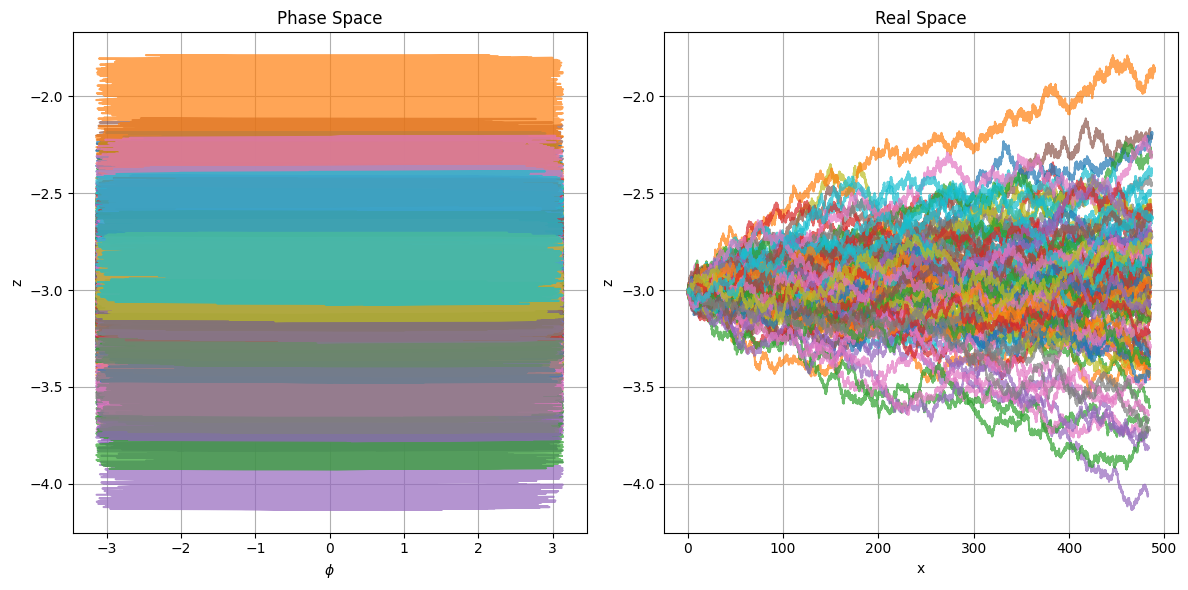

(<Figure size 1200x600 with 2 Axes>,
 (<Axes: title={'center': 'Phase Space'}, xlabel='$\\phi$', ylabel='z'>,
  <Axes: title={'center': 'Real Space'}, xlabel='x', ylabel='z'>))

In [46]:
plot_phase_and_real_space(stochastic_trajs)

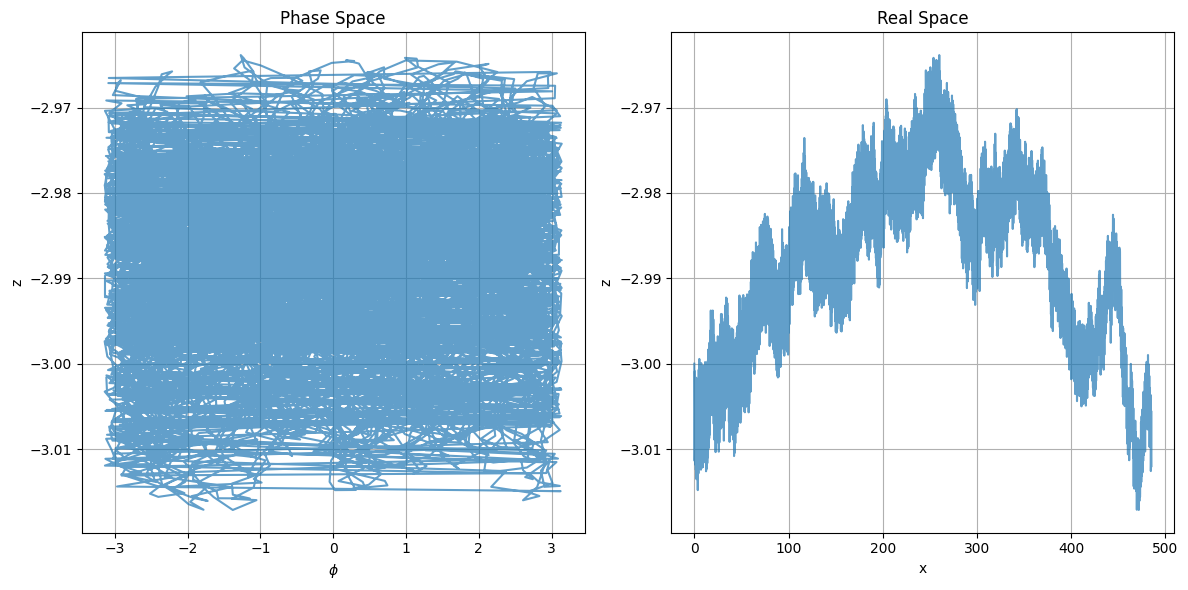

(<Figure size 1200x600 with 2 Axes>,
 (<Axes: title={'center': 'Phase Space'}, xlabel='$\\phi$', ylabel='z'>,
  <Axes: title={'center': 'Real Space'}, xlabel='x', ylabel='z'>))

In [47]:
mean_traj = [np.mean(stochastic_trajs, axis=0)]

plot_phase_and_real_space(mean_traj)

## Fokker Planck